In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

df = pd.read_csv('insurance.csv')
print('shape:', df.shape)
display(df.head())


shape: (1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


1.1 Проверка наличия пропусков и выбросов

In [2]:
print('\nПропуски по столбцам:')
print(df.isnull().sum())


num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
outliers = {}
for c in num_cols:
    Q1 = df[c].quantile(0.25)
    Q3 = df[c].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    mask = (df[c] < low) | (df[c] > high)
    outliers[c] = int(mask.sum())
print('Выбросы:')
print(outliers)


Пропуски по столбцам:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
Выбросы:
{'age': 0, 'bmi': 9, 'children': 0, 'charges': 139}


1.2 Привести категориальные признаки к числовым

In [3]:
df_proc = df.copy()
df_proc['sex'] = df_proc['sex'].map({'male':0, 'female':1})
df_proc['smoker'] = df_proc['smoker'].map({'no':0, 'yes':1})
df_proc = pd.get_dummies(df_proc, columns=['region'], drop_first=True)
print('Колонки после обработки:')
print(df_proc)

Колонки после обработки:
      age  sex     bmi  children  smoker      charges  region_northwest  \
0      19    1  27.900         0       1  16884.92400             False   
1      18    0  33.770         1       0   1725.55230             False   
2      28    0  33.000         3       0   4449.46200             False   
3      33    0  22.705         0       0  21984.47061              True   
4      32    0  28.880         0       0   3866.85520              True   
...   ...  ...     ...       ...     ...          ...               ...   
1333   50    0  30.970         3       0  10600.54830              True   
1334   18    1  31.920         0       0   2205.98080             False   
1335   18    1  36.850         0       0   1629.83350             False   
1336   21    1  25.800         0       0   2007.94500             False   
1337   61    1  29.070         0       1  29141.36030              True   

      region_southeast  region_southwest  
0                False         

1.3 Вычисление парных корреляций признаков

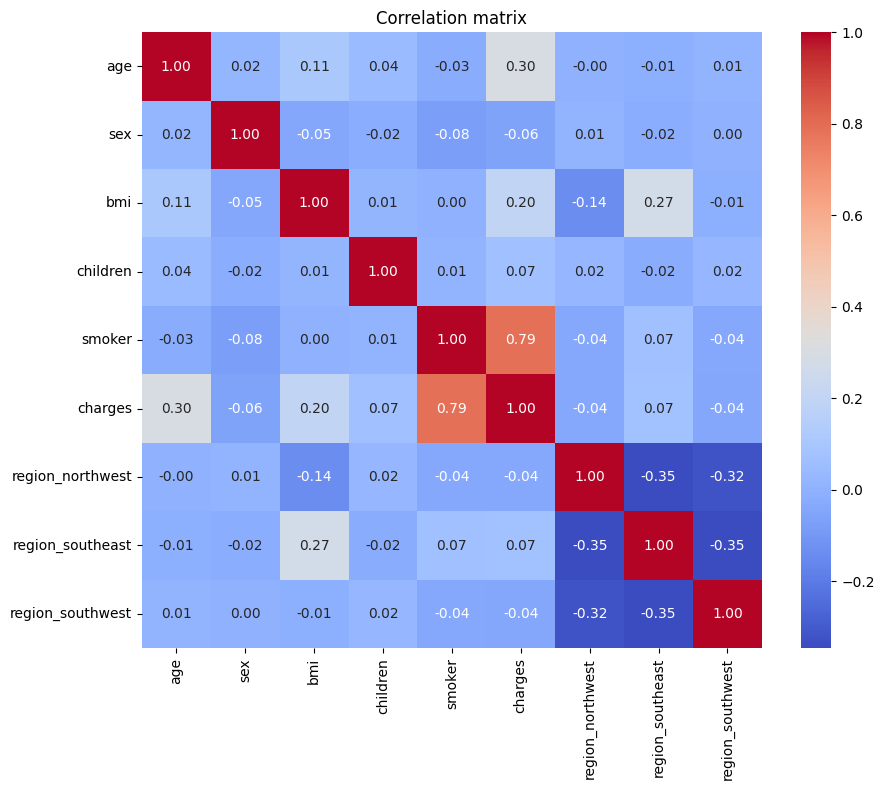

In [4]:
corr = df_proc.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

2. Построить модель линейной регрессии и подобрать параметры:
    1. аналитически

In [7]:
y = df_proc['charges'].values.reshape(-1,1)
X = df_proc.drop(columns=['charges']).values
feature_names = df_proc.drop(columns=['charges']).columns.tolist()


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE)


print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

X_train_const = np.hstack([np.ones((X_train.shape[0],1)), X_train]).astype(float)
X_val_const = np.hstack([np.ones((X_val.shape[0],1)), X_val])
X_test_const = np.hstack([np.ones((X_test.shape[0],1)), X_test]).astype(float)
X_train_s_const = np.hstack([np.ones((X_train_s.shape[0],1)), X_train_s])
X_val_s_const = np.hstack([np.ones((X_val_s.shape[0],1)), X_val_s])
X_test_s_const = np.hstack([np.ones((X_test_s.shape[0],1)), X_test_s])

def normal_equation(X, y):
    XtX = X.T.dot(X)
    Xty = X.T.dot(y)
    theta = np.linalg.pinv(XtX).dot(Xty)
    return theta


theta_analytic = normal_equation(X_train_const, y_train)
y_pred_test_anal = X_test_const.dot(theta_analytic)
print('Среднеквадратичная ошибка:', mean_squared_error(y_test, y_pred_test_anal))

Shapes: (802, 8) (268, 8) (268, 8)
Среднеквадратичная ошибка: 33753730.19041813


2. численно, с помощью методов градиентного спуска (реализовать самому)

In [36]:
def gradient_descent(X, y, lr=0.01, n_iters=10000, tol=1e-8, verbose=False, l2_reg=0.0):
    n_samples, n_features = X.shape
    theta = np.zeros((n_features,1))
    prev_loss = None
    losses = []
    for i in range(n_iters):
        preds = X.dot(theta)
        error = preds - y
        loss = (1.0/(2*n_samples)) * np.sum(error**2) + (l2_reg/(2*n_samples)) * np.sum(theta[1:]**2)
        grad = (1.0/n_samples) * X.T.dot(error)
        grad[1:] += (l2_reg/n_samples) * theta[1:]
        theta -= lr * grad
        losses.append(loss)
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            if verbose:
                print(f' {i}')
            break
        prev_loss = loss
    return theta, losses


theta_gd, losses = gradient_descent(X_train_s_const, y_train, lr=0.1, n_iters=20000)
y_pred_test_gd = X_test_s_const.dot(theta_gd)
print('Квадр. ошибка:', mean_squared_error(y_test, y_pred_test_gd))

Квадр. ошибка: 33753730.549339265


Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:
1. аналитически

In [35]:
def ridge_normal_equation(X, y, lmbda):
    n_features = X.shape[1]
    L = np.eye(n_features)
    L[0,0] = 0.0
    A = X.T.dot(X) + lmbda * L
    b = X.T.dot(y)
    theta = np.linalg.pinv(A).dot(b)
    return theta

lambdas = np.logspace(-4, 4, 30)
val_mses = []

for l in lambdas:
    th = ridge_normal_equation(X_train_const, y_train, l)
    val_mses.append(mean_squared_error(y_val, X_val_const.dot(th)))

best_lambda = lambdas[int(np.argmin(val_mses))]
print('lambda (analytic):', best_lambda)

theta_ridge_best = ridge_normal_equation(X_train_const, y_train, best_lambda)

print('\nОптимальные веса Ridge (аналитически):')
for name, coef in zip(['Intercept'] + feature_names, theta_ridge_best.ravel()):
    print(f'{name}: {coef:.4f}')

y_pred_test_ridge = X_test_const.dot(theta_ridge_best)
mse_test_ridge = mean_squared_error(y_test, y_pred_test_ridge)

print(f'\nОшибка: {mse_test_ridge:.2f}')



lambda (analytic): 0.0001

Оптимальные веса Ridge (аналитически):
Intercept: -12146.2334
age: 253.8424
sex: 157.9294
bmi: 340.7869
children: 404.2235
smoker: 23249.8634
region_northwest: -460.5546
region_southeast: -594.3031
region_southwest: -749.2137

Ошибка: 33753738.37


2. численно

In [34]:
def gradient_descent_ridge(X, y, lr=0.01, n_iters=10000, tol=1e-8, lmbda=0.0, verbose=False):
    n_samples, n_features = X.shape
    theta = np.zeros((n_features,1))
    prev_loss = None
    losses = []

    for i in range(n_iters):
        preds = X.dot(theta)
        error = preds - y
        loss = (1/(2*n_samples)) * np.sum(error**2) + (lmbda/(2*n_samples)) * np.sum(theta[1:]**2)
        grad = (1/n_samples) * X.T.dot(error)
        grad[1:] += (lmbda/n_samples) * theta[1:]
        theta -= lr * grad
        losses.append(loss)

        if prev_loss is not None and abs(prev_loss - loss) < tol:
            if verbose:
                print(f'{i}')
            break
        prev_loss = loss

    return theta, losses

lambdas = np.logspace(-4, 4, 30)
best_mse = np.inf
best_theta = None
best_lambda = None

for l in lambdas:
    theta, _ = gradient_descent_ridge(X_train_s_const, y_train, lr=0.1, n_iters=20000, lmbda=l)
    mse_val = mean_squared_error(y_val, X_val_s_const.dot(theta))
    if mse_val < best_mse:
        best_mse = mse_val
        best_theta = theta
        best_lambda = l

print('Best lambda:', best_lambda)
print('\nОптимальные веса(численно):')
for name, coef in zip(['Intercept'] + feature_names, best_theta.ravel()):
    print(f'{name}: {coef:.4f}')

y_pred_test = X_test_s_const.dot(best_theta)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f'\nОшибка: {mse_test:.2f}')



Best lambda: 0.0001

Оптимальные веса(численно):
Intercept: 13039.7603
age: 3568.6519
sex: 78.9453
bmi: 2092.5546
children: 500.1366
smoker: 9398.4883
region_northwest: -194.0143
region_southeast: -257.9791
region_southwest: -331.3800

Ошибка: 33753732.03


4. Сравнение моделей

In [33]:
mean_pred = np.mean(y_train)
y_pred_const = np.full_like(y_test, mean_pred)
mse_const = mean_squared_error(y_test, y_pred_const)
print(f'константной модели: {mse_const:.2f}')

y_pred_ols_analytic = X_test_const.dot(theta_analytic)
mse_ols_analytic = mean_squared_error(y_test, y_pred_ols_analytic)
print(f'аналитически: {mse_ols_analytic:.2f}')

y_pred_ols_gd = X_test_s_const.dot(theta_gd)
mse_ols_gd = mean_squared_error(y_test, y_pred_ols_gd)
print(f'численно (градиентный спуск): {mse_ols_gd:.2f}')

y_pred_ridge_analytic = X_test_const.dot(theta_ridge_best)
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge_analytic)
print(f'с регул аналитически: {mse_ridge_analytic:.2f}')

y_pred_ridge_gd = X_test_s_const.dot(best_theta)
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)
print(f'с регул численно (градиентный спуск): {mse_ridge_gd:.2f}')


константной модели: 155253835.62
аналитически: 33753730.19
численно (градиентный спуск): 33753730.55
с регул аналитически: 33753738.37
с регул численно (градиентный спуск): 33753732.03
